In [1]:
from helper_functions import load_data_for_all_three
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_lg")
from tqdm import tqdm, tqdm_notebook

c:\Users\KSpicer\Anaconda3\envs\python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_data, labels = load_data_for_all_three('data')
df = pd.DataFrame(list(zip(text_data, labels)), columns=['text_data', 'label'])

Processing file: fitzgerald_all_the_sad.txt
Processing file: fitzgerald_bablyon_revisited.txt
Processing file: fitzgerald_beautiful_and_damned.txt
Processing file: fitzgerald_flappers_and_philosophers.txt
Processing file: fitzgerald_gatsby.txt
Processing file: fitzgerald_tales_jazz_age.txt
Processing file: fitzgerald_tender_is.txt
Processing file: fitzgerald_the_vegtable.txt
Processing file: fitzgerald_this_side.txt
Processing file: hemingway_across_the_river.txt
Processing file: hemingway_bell_tolls.txt
Processing file: hemingway_collected_stories.txt
Processing file: hemingway_farewell.txt
Processing file: hemingway_green_hills_africa.txt
Processing file: hemingway_in_our_time.txt
Processing file: hemingway_men_without_women.txt
Processing file: hemingway_old_man.txt
Processing file: hemingway_sun_also.txt
Processing file: hemingway_ten_poems.txt
Processing file: hemingway_winner_take_nothing.txt
Processing file: steinbeck_cannery_row.txt
Processing file: steinbeck_east_of_eden.txt
P

In [6]:
nlp.max_length = 2000000
# define a function to extract POS tags from a text and return a dictionary with the counts of each tag
def get_pos_counts(text):
    doc = nlp(text)
    pos_counts = {}
    for token in doc:
        pos = token.pos_
        if pos in pos_counts:
            pos_counts[pos] += 1
        else:
            pos_counts[pos] = 1
        dep = token.dep_
        if dep != "":
            dep_key = f"{pos}_{dep}"
            if dep_key in pos_counts:
                pos_counts[dep_key] += 1
            else:
                pos_counts[dep_key] = 1
    return pos_counts

# apply the get_pos_counts function to each row in the dataframe
#df["pos_counts"] = df["text_data"].progress_apply(get_pos_counts)

def get_pos_counts_wrapper(text):
    return get_pos_counts(text)

df['text_data'] = df['text_data'].str.replace('\n', ' ')
df["pos_counts"] = list(tqdm(df["text_data"].apply(get_pos_counts_wrapper)))

# extract the POS tags and their counts into separate columns in the dataframe
pos_tags = set.union(*[set(d.keys()) for d in df["pos_counts"]])

df = df.rename(columns={'pos_counts': 'pos_counts_orig'})

pos_series_list = []
for tag in pos_tags:
    pos_series_list.append(df["pos_counts_orig"].apply(lambda x: x.get(tag, 0)))

# concatenate all the series into a single dataframe
pos_counts_df = pd.concat(pos_series_list, axis=1)

# rename the columns to include the POS tag
pos_counts_df.columns = [tag + '_count' for tag in pos_tags]

# join the new dataframe to the original dataframe
df = df.join(pos_counts_df)
df.head()

100%|██████████| 26/26 [00:00<00:00, 2662.53it/s]


,text_data,label,pos_counts_orig,DET,PRON,PART,INTJ,SCONJ,AUX,X,...,AUX_oprd_count,PART_ROOT_count,NUM_csubj_count,X_nsubjpass_count,DET_nmod_count,PUNCT_relcl_count,CCONJ_xcomp_count,ADV_xcomp_count,INTJ_preconj_count,PART_intj_count
0,"THE RICH BOYBegin with an individual, and befo...",0,"{'DET': 5085, 'DET_det': 4972, 'ADJ': 4181, 'A...",5085,8450,1666,181,1528,3669,83,...,1,6,0,0,0,1,0,0,0,0
1,"""And where's Mr. Campbell?"" Charlie asked.""Gon...",0,"{'PUNCT': 1384, 'PUNCT_punct': 1362, 'CCONJ': ...",604,1143,276,22,167,487,16,...,0,0,0,0,0,0,0,0,0,0
2,CONTENTSBOOK ONE I. ANTHONY PATCH II. PORTRAI...,0,"{'PROPN': 7332, 'PROPN_ROOT': 331, 'NUM': 1312...",10480,14529,2871,584,2716,7147,155,...,2,7,0,2,1,3,0,1,1,0
3,Flappers and PhilosophersThe Offshore PirateIT...,0,"{'NOUN': 10343, 'NOUN_nmod': 75, 'CCONJ': 2206...",4749,7536,1485,231,1233,3293,98,...,0,4,0,0,0,0,0,0,0,0
4,"Then wear the gold hat, if that will move he...",0,"{'SPACE': 52, 'SPACE_dep': 52, 'ADV': 2870, 'A...",4044,6257,1164,94,1059,2261,92,...,0,3,0,0,0,0,1,1,0,0


In [8]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# preprocess the text data and split it into training and testing sets
X = df['text_data']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a TfidfVectorizer object to convert the text data into feature vectors
tfidf = TfidfVectorizer(use_idf=False, norm='l2', tokenizer=nltk.word_tokenize)

# fit the vectorizer on the training data and transform the text data into feature vectors
X_train_tfidf =tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# concatenate the POS tag counts with the Tfidf feature vectors
X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))

# train a logistic regression model on the concatenated feature vectors
lr = LogisticRegression(random_state=42)
lr.fit(X_train_full, y_train)

# evaluate the model on the testing set
acc = lr.score(X_test_full, y_test)
print('Accuracy: {:.2f}'.format(acc))

c:\Users\KSpicer\Anaconda3\envs\python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\825954939.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\825954939.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))


Accuracy: 0.67


c:\Users\KSpicer\Anaconda3\envs\python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a TfidfVectorizer object to convert the text data into feature vectors
tfidf = TfidfVectorizer(use_idf=False, norm='l2', tokenizer=nltk.word_tokenize)
X_train_tfidf =tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# concatenate the POS tag counts with the Tfidf feature vectors
X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))

# Create a KNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model on the training set
knn.fit(X_train_full, y_train)

# Predict the classes of the testing set
y_pred = knn.predict(X_test_full)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

c:\Users\KSpicer\Anaconda3\envs\python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.5


C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\1155713337.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\1155713337.py:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))


In [13]:
from sklearn.tree import DecisionTreeClassifier

# create a TfidfVectorizer object to convert the text data into feature vectors
tfidf = TfidfVectorizer(use_idf=False, norm='l2', tokenizer=nltk.word_tokenize)
X_train_tfidf =tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# concatenate the POS tag counts with the Tfidf feature vectors
X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))

# Create a decision tree classifier object
dt = DecisionTreeClassifier(max_depth=5)

# Fit the classifier on the training data
dt.fit(X_train_full, y_train)

# Predict the labels for the test data
y_pred = dt.predict(X_test_full)

# Evaluate the performance of the classifier
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

c:\Users\KSpicer\Anaconda3\envs\python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.8333333333333334


C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\1437996380.py:9: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_full = np.hstack((X_train_tfidf.toarray(), df.iloc[X_train.index][pos_tags].values))
C:\Users\KSpicer\AppData\Local\Temp\ipykernel_10520\1437996380.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_test_full = np.hstack((X_test_tfidf.toarray(), df.iloc[X_test.index][pos_tags].values))


<AxesSubplot: >

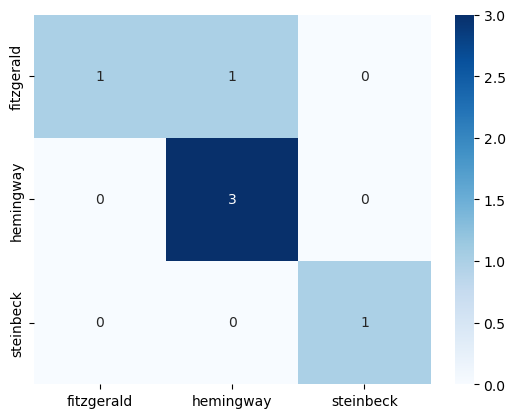

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["fitzgerald", "hemingway", "steinbeck"], yticklabels=["fitzgerald", "hemingway", "steinbeck"])

Accuracy score: 1.00


<AxesSubplot: >

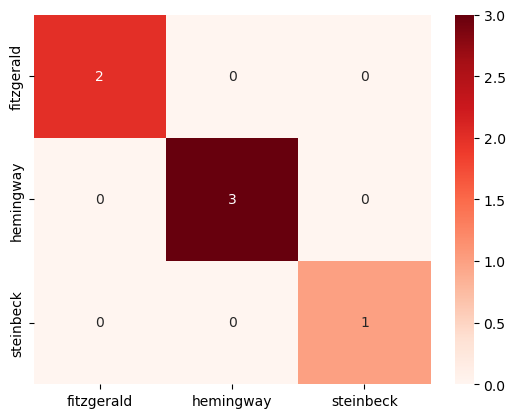

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Initialize the GBM classifier
gbm = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the classifier on the training data
gbm.fit(X_train_full, y_train)

# Predict the labels for the test data
y_pred = gbm.predict(X_test_full)

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy:.2f}")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn's heatmap function
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Reds", fmt="d", xticklabels=["fitzgerald", "hemingway", "steinbeck"], yticklabels=["fitzgerald", "hemingway", "steinbeck"])